# Analyse grammaticale des requêtes FR (cash ou cb)

In [7]:
from functools import reduce
from os.path import join
import random
import re
import time

from gensim.utils import deaccent
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import spacy
from spacy import displacy
import tweepy
import tqdm

In [25]:
pd.options.display.max_colwidth = None
pd.options.display.max_columns = 30
tqdm.tqdm.pandas()

### Constants (queries)

In [9]:
WHAT_CASH = [
    'espece',  'especes', 'billets', 'billet', 'piece', 'pieces', 'monnaie', 'cash',
    'liquide', 'retraits', 'retrait', 'distributeur', 'distributeurs', '" DAB "', 'guichet', 'guichets'
]
HOW_CASH = [
    'paiement', 'paiements', 'payer', 'reglements', 'reglement', 'regler', 'achat',
    'achats', 'acheter', 'retirer', 'depenser', 'depense', 'depenses'
]

WHAT_CB = [
    'carte', 'cartes', '" CB "', '"sans contact"', '" visa "', 'mastercard',
    '"cash back"', '" NFC "', '"Google Pay"', '"ApplePay"', '"Paylib"', '"Lydia"',
    '"Lyf Pay"', '"Alipay"', '"Samsung Pay"', '"Stocard Pay"', '"paiements mobiles"', '"chèques"'
]
HOW_CB = [
    'paiement', 'paiements', 'payer', 'reglement', 'reglements', 'regler','achat', 'achats',
    'acheter', 'retirer', 'virement', 'virements', 'virer', 'depenser', 'depense', 'depenses'
]

QUERIES = dict(cash = WHAT_CASH + HOW_CASH, cb = WHAT_CB + HOW_CB)

QUERIES_PATH = "/home/cash/output/cleaned_queries/with_geoloc"

## 1. Importing dataframe

In [10]:
df_cash = pd.read_pickle(join(QUERIES_PATH, "query_fr_cash_cleaned_geoloc.pickle"))
df_cash["datetime"] = pd.to_datetime(df_cash["datetime"])
df_cash["created_at"] = df_cash["datetime"]
df_cash.set_index("datetime", inplace=True)

df_cb = pd.read_pickle(join(QUERIES_PATH, "query_fr_cb_cleaned_geoloc.pickle"))
df_cb["datetime"] = pd.to_datetime(df_cb["datetime"])
df_cb["created_at"] = df_cb["datetime"]
df_cb.set_index("datetime", inplace=True)

In [11]:
dfs = dict(cash=df_cash, cb=df_cb)

## 2. Dependency/grammatical parsing

In [45]:
def get_dep_info(tweet, obj_only=False, what="cb"):
    lst = []
    doc = nlp(tweet)
    
    for token in (token for token in doc if token.text in QUERIES[what]):
        if token.dep_ == 'obj':
            lst += [{"word": token.text, "parent": token.head.text, 'enfant': [child.text for child in token.children]}]
    
    return lst

def build_dep_df(df):
    grammatical_list_serie = df.tweet.str.lower().progress_apply(get_dep_info)
    parent_word = pd.json_normalize(grammatical_list_serie.explode().dropna())[["parent", "word", "enfant"]]
    
    parent_word_count = parent_word.groupby(["parent", "word"]).size().rename("count").reset_index()[lambda df: df["count"] > 10]
    parent_word_count["len_parent"] = parent_word_count.groupby("parent")["count"].transform(sum)
    parent_word_count["len_word"] = parent_word_count.groupby("word")["count"].transform(sum)
    parent_word_count["p"] = parent_word_count["count"] / (parent_word_count.len_word + parent_word_count.len_parent)
    
    return parent_word, parent_word_count

In [13]:
nlp = spacy.load("fr_core_news_md")

### 2.1. NLP analysis (small example on 1 tweet)

In [15]:
text = df_cb.sample(1).tweet.iloc[0]
doc = nlp(text)
print(doc)

@FloDoof J’avais acheter toute les cartes jackpot depuis le début de l’année, après me demande pas comment j’ai fait, c’est technique lol


#### Visualizing dependency parsing

In [26]:
displacy.render(doc, style="dep", options={"distance": 80})

#### Entity recognition

In [27]:
displacy.render(doc, style="ent", options={"distance": 80})

### 2.2. Build dependency dataframe on extract of 20 000 tweets

In [ ]:
parent_word, parent_word_count = build_dep_df(dfs["cb"].head(20_000))

 34%|███▍      | 6859/20000 [02:05<04:01, 54.37it/s]

In [43]:
parent_word_count

,parent,word,count,len_parent,len_word,p
79,privilégiez,paiement,39,39,39,0.5


<AxesSubplot:xlabel='parent', ylabel='word'>

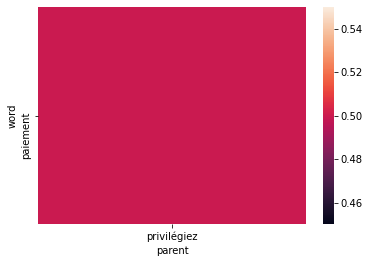

In [42]:
sns.heatmap(data=parent_word_count.pivot(index="word", columns="parent", values="p"))

In [38]:
df_grammatical.parent.value_counts().head(30)

privilégiez    39
payer          13
régler          9
offrez          5
retirer         4
lance           4
faire           4
avoir           4
utiliser        4
acceptent       4
effectuer       4
=               4
acheté          4
cherchez        4
a               4
valider         3
faciliter       3
représente      3
ai              3
acheter         3
utilisant       3
fait            2
présenter       2
bloque          2
utilise         1
procurer        1
déploient       1
mis             1
sert            1
recevoir        1
Name: parent, dtype: int64

<AxesSubplot:>

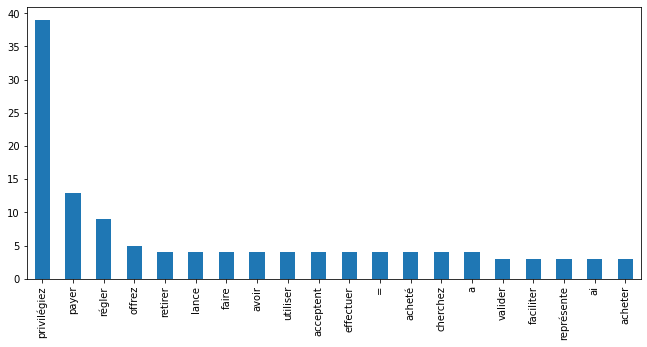

In [39]:
df_grammatical.parent.value_counts().head(20).plot(kind="bar", figsize=(11, 5))